## Advanced Regression Techniques - Work Sessions

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
train = "../data/train.csv"
test = "../data/test.csv"

### Modelos de ensembling
Modelos que agrupan otro tipo de modelos más simples y que eligen aquel que produzca mejor output. Pueden ser de dos tipos:
- Bagging - RandomForest (boost aggregation): subdividir el problema en otros más pequeños, que utilicen árboles más pequeños, agregándolos a la hora de predecir, añadiendo una componente de aleatoriedad (con reemplazo) a la hora de generar esa sudivisión. Paraleliza los árboles.
- Boosting - GradientBoosting (boost): a la hora de subdividir el problema, elegimos aquellos que están produciendo un mayor error a la hora de predecir los árboles, para mejorar ese el primero. No paraleliza, ya que el segundo depende del primero. Mediante la media ponderamos el error los árboles a la hora de scorear

In [6]:
import pandas as pd
import numpy as np

In [7]:
train_df = pd.read_csv(train)
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Imports

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor

#### Functions

In [16]:
# One Hot Encoding: we define a function to apply OHE and drop the original variable
def fun_ohe (df_in, variable, ohe):
    if not ohe:
        ohe = OneHotEncoder(sparse_output=False)
    ohe.fit(df_in[[variable]])
    ohe_df = pd.DataFrame(ohe.transform(df_in[[variable]]),
                 columns = ohe.get_feature_names_out([variable]))
    ohe_df.set_index(df_in.index, inplace=True)
    return pd.concat([df_in, ohe_df], axis=1).drop([variable], axis=1), ohe

# Apply OHE over the whole variables required providing OHEs for its usage later on for test dataset
def apply_fun_ohe(df_in, variable, ohe=[]):
    if isinstance(variable, list):
        ohes = list()
        for i in range(len(variable)):
            if ohe:
                df_in, ohE = fun_ohe(df_in, variable[i], ohe[i])
            else:
                df_in, ohE = fun_ohe(df_in, variable[i], ohe=[])
            ohes.append(ohE)
    else:
        df_in, ohes = fun_ohe(df_in, variable, ohe)
    return df_in, ohes

# Extracts X_train, X_val, y_train, y_val
def split_train_test(X, y, size, seed):
    return train_test_split(
        X, y, test_size=size, random_state=seed)

# We'll iterate through different number of min_samples_leaf and max_depth, 
# train the model and test it using RMSE in both train and validations sets
# Produces: (max_depth, min_samples_leaf, error_train, error_val, train_dict, val_dict)
def train_validate_best_params(X_train, X_val, y_train, y_val, min_max_samples_leaf, min_max_depth):
    result_train_dict = {}
    result_val_dict = {}
    cand_metrics = 1 
    for m in range(min_max_depth[0], min_max_depth[1] + 1):
        for n in range(min_max_samples_leaf[0], min_max_samples_leaf[1] + 1, 1):
            tree_reg = DecisionTreeRegressor(random_state=42, min_samples_leaf=n, max_depth=m)
            tree_reg.fit(X_train, y_train)

            train_predicted = tree_reg.predict(X_train)
            val_predicted = tree_reg.predict(X_val)

            result_train_dict[m, n] = mean_squared_error(np.log(y_train), np.log(train_predicted), squared = False)
            result_val_dict[m, n] = mean_squared_error(np.log(y_val), np.log(val_predicted), squared = False)
            if cand_metrics > result_val_dict.get((m, n)):
                cand_metrics = result_val_dict.get((m, n))
                best = (m, n, result_train_dict[m, n], result_val_dict[m, n], result_train_dict, result_val_dict)

    return best

# Obtain submission from test
def obtain_submission(min_samples_leaf, max_depth, X, y, test_path, ohes):
    # Train tree
    tree_reg = DecisionTreeRegressor(random_state=42, min_samples_leaf=min_samples_leaf, max_depth=max_depth)
    tree_reg.fit(X, y)
    train_predicted = tree_reg.predict(X)
    print(f"MSALE train in-full: {mean_squared_error(np.log(y), np.log(train_predicted), squared = False)}")

    # Load test and adjust
    test_df = pd.read_csv(test)
    X_test = apply_fun_ohe(test_df[non_nulls[:-1]], categorical, ohes)[0]
    test_predicted = test_df[['Id']].copy()
    test_predicted['SalePrice'] = tree_reg.predict(X_test.fillna(0))

    return test_predicted

# Flatten element of type ("a", ("b", ("c", ("d", ("e"))))) to ("a", "b", "c", "d", "e")
def flatten(coll):
    for i in coll:
        if isinstance(i, tuple) and not isinstance(i, str):
            for subc in flatten(i):
                yield subc
        else:
            yield i

In [10]:
train_df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [12]:
# Non-nulls train
non_nulls = [
    "LotArea", "Street", "LotShape", "LandContour", "Utilities", "LotConfig", "LandSlope", "Neighborhood", "Condition1", "Condition2", 
    "BldgType", "HouseStyle", "OverallQual", "OverallCond", "YearBuilt", "YearRemodAdd", "RoofStyle", "RoofMatl", "Exterior1st", 
    "Exterior2nd", "ExterQual", "ExterCond", "Foundation", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "Heating", 
    "HeatingQC", "CentralAir", "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea", "BsmtFullBath", "BsmtHalfBath", "FullBath", 
    "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "KitchenQual", "TotRmsAbvGrd", "Functional", "Fireplaces", "GarageCars", "GarageArea", 
    "PavedDrive", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "MoSold", "YrSold", "SaleType", 
    "SaleCondition", "SalePrice"
]

# Delete those columns that have nulls on test
nulls_test = [
    "Utilities", "Exterior1st", "Exterior2nd", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", 
    "BsmtHalfBath", "KitchenQual", "Functional", "GarageCars", "GarageArea", "SaleType"
]

In [13]:
# # Select columns
# columns = [col for col in non_nulls if (col not in nulls_test) and col != "SalePrice"]
# 
# # Initially, to set an initial limit we will take into account all non nulls.
# X, y = train_df[columns], train_df["SalePrice"]
# 
# # Extract from X categorical columns columns
# cat_cols = X.select_dtypes(include=[object]).columns.to_list()
# 
# # Apply OHE to categorical variables, raising an error in case we still have categorical features
# X, ohes = apply_fun_ohe(X, cat_cols)
# if X.select_dtypes(include=[object]).columns.to_list() != list():
#     raise ValueError("OneHotEncoder has not worked as expected")
# 
# print("Beginning iteration over test_sizes")
# print("--------------------------------------------------------")
# for test_size in range(5, 31):
#     print(f"Test size: {test_size}%")
#     # Extracts X_train, X_val, y_train, y_val
#     X_train, X_val, y_train, y_val = split_train_test(X, y, test_size/100, 2023)
# 
#     # Extract parameters for DecisionTreeRegressor
#     max_depth, min_samples_leaf, error_train, error_val, train_dict, val_dict = train_validate_best_params(
#         X_train, X_val, y_train, y_val, (1, 50), (1, 50))
# 
#     print(f"DecisionTreeRegressor best parameters obtained using")
#     print(f"\tmax_depth: {max_depth} - min_samples_leaf: {min_samples_leaf}")
#     print(f"Obtained MSALE on train: {error_train}")
#     print(f"Obtained MSALE on validation: {error_val}")
#     print("--------------------------------------------------------")
#     # Train DecisionTreeRegressor with the best parameters chosen from before
#     tree_reg = DecisionTreeRegressor(
#         random_state=42, min_samples_leaf=min_samples_leaf, max_depth=max_depth)
#     tree_reg.fit(X, y)
# 
#     tree_importances = pd.Series(
#     tree_reg.tree_.compute_feature_importances(normalize=True), index=X.columns) \
#         .sort_values(ascending=False)

In [17]:
# --------------------------------------------------------
# Test size: 22%
# DecisionTreeRegressor best parameters obtained using
# 	max_depth: 8 - min_samples_leaf: 16
# Obtained MSALE on train: 0.15612003114684725
# Obtained MSALE on validation: 0.18707959721888404
# --------------------------------------------------------
# Select columns
columns = [col for col in non_nulls if (col not in nulls_test) and col != "SalePrice"]

# Initially, to set an initial limit we will take into account all non nulls.
X, y = train_df[columns], train_df["SalePrice"]

# Extract from X categorical columns columns
cat_cols = X.select_dtypes(include=[object]).columns.to_list()

# Apply OHE to categorical variables, raising an error in case we still have categorical features
X, ohes = apply_fun_ohe(X, cat_cols)
if X.select_dtypes(include=[object]).columns.to_list() != list():
    raise ValueError("OneHotEncoder has not worked as expected")

# Extracts X_train, X_val, y_train, y_val
X_train, X_val, y_train, y_val = split_train_test(X, y, 22/100, 2023)

# Extract parameters for DecisionTreeRegressor
max_depth, min_samples_leaf, error_train, error_val, train_dict, val_dict = train_validate_best_params(
    X_train, X_val, y_train, y_val, (1, 50), (1, 50))

print("DecisionTreeRegressor best parameters obtained using")
print(f"\tmax_depth: {max_depth} - min_samples_leaf: {min_samples_leaf}")
print(f"Obtained MSALE on train: {error_train}")
print(f"Obtained MSALE on validation: {error_val}")

# Train DecisionTreeRegressor with the best parameters chosen from before
tree_reg = DecisionTreeRegressor(
    random_state=42, min_samples_leaf=min_samples_leaf, max_depth=max_depth)
tree_reg.fit(X, y)

tree_importances = pd.Series(
tree_reg.tree_.compute_feature_importances(normalize=True), index=X.columns) \
    .sort_values(ascending=False)

DecisionTreeRegressor best parameters obtained using
	max_depth: 8 - min_samples_leaf: 16
Obtained MSALE on train: 0.15612003114684728
Obtained MSALE on validation: 0.18707959721888393


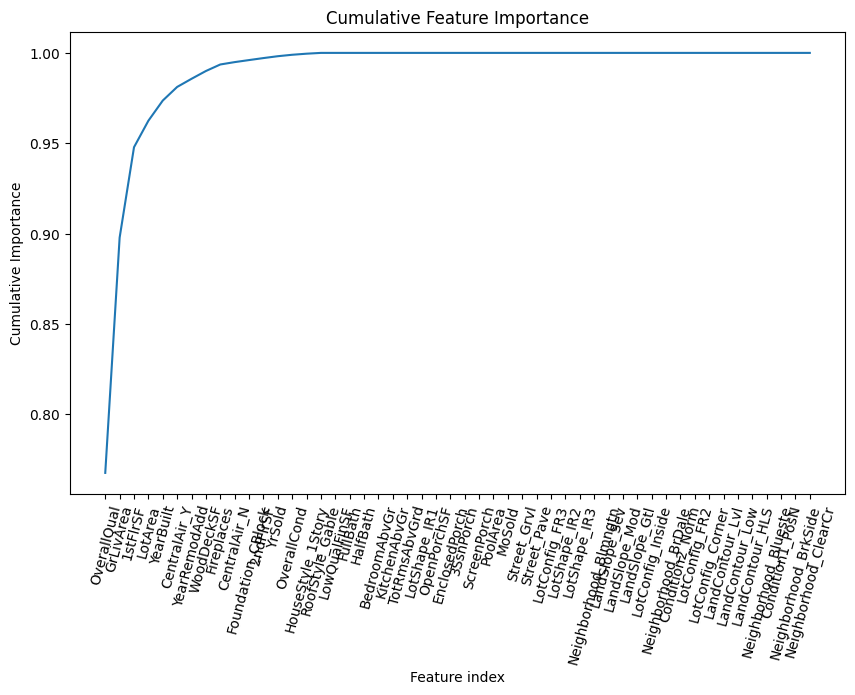

In [18]:
import matplotlib.pyplot as plt
sorted_indices = np.argsort(tree_importances)[::-1]  # Sort in descending order
cumulative_importances = np.cumsum(tree_importances[sorted_indices])
index_list = tree_importances.sort_values(ascending=False).index.tolist()[:50]

plt.figure(figsize=(10, 6))
plt.plot(cumulative_importances[:50])
plt.xticks(ticks=range(0, len(index_list)), labels=index_list, rotation=75)
plt.xlabel('Feature index')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.show()

In [19]:
cumulative_importances.head(20)

OverallQual          0.767701
GrLivArea            0.897825
1stFlrSF             0.947834
LotArea              0.962486
YearBuilt            0.973636
CentralAir_Y         0.981167
YearRemodAdd         0.985671
WoodDeckSF           0.989981
Fireplaces           0.993587
CentralAir_N         0.994900
Foundation_CBlock    0.996029
2ndFlrSF             0.997133
YrSold               0.998164
OverallCond          0.998963
HouseStyle_1Story    0.999558
RoofStyle_Gable      1.000000
HeatingQC_Po         1.000000
ExterCond_Po         1.000000
ExterQual_Gd         1.000000
ExterQual_TA         1.000000
dtype: float64

In [20]:
non_important = list(set(col.split("_")[0] for col in tree_importances[tree_importances == 0].index.to_list()))
print(f"Non important: {non_important}")

Non important: ['LotShape', 'BldgType', 'HouseStyle', 'Street', 'ExterQual', 'PavedDrive', 'HalfBath', 'FullBath', 'RoofMatl', 'HeatingQC', 'PoolArea', 'LotConfig', 'LandSlope', 'ExterCond', 'Condition1', 'OpenPorchSF', 'EnclosedPorch', 'Foundation', 'BedroomAbvGr', 'ScreenPorch', 'LandContour', 'Condition2', 'LowQualFinSF', 'RoofStyle', '3SsnPorch', 'SaleCondition', 'TotRmsAbvGrd', 'KitchenAbvGr', 'Neighborhood', 'Heating', 'MoSold']


### Feature Engineering
Podemos llevarlas a cabo de distintas formas:
- Temporal
- Normalizando
- Encoding, transformando variables categóricas a numéricas
- Transformaciones, preferiblemente no lineales (dependiendo de la función a tratar)

**IMPORTANTE**: Documentar en diccionarios de datos la forma en la que hemos creado las variables, para que no se nos olvide

In [21]:
def fill_nulls(df, drop_low_sample=True):
    if drop_low_sample:
        # Remove columns with a high level of nulls and columns with a lower sample coverage than 80%
        df = df.drop(
            columns=["MiscFeature", "Fence", "PoolQC", "Alley", "FireplaceQu"] + ['MSZoning', 'Utilities']
        )
    
    # Fill nulls
    df["MasVnrArea"] = np.where(
        (df["MasVnrType"] == "None") & (df["MasVnrArea"] != 0), 0, df["MasVnrArea"])
    df["MasVnrArea"].fillna(0)
    df["MasVnrType"] = np.where(
        (df["MasVnrType"] != "None") & (df["MasVnrArea"] == 0), "None", df["MasVnrType"])
    df["MasVnrType"].fillna("None")
    df["BsmtExposure"] = np.where(
        df["BsmtExposure"].isna() & df["BsmtCond"].notna(), df["BsmtExposure"].mode()[0], df["BsmtExposure"])
    df["BsmtExposure"].fillna("NA")
    df["BsmtFinType2"] = np.where(
        df["BsmtFinType2"].isna() & (df["BsmtFinSF2"] != 0), df["BsmtFinType2"].mode()[0], df["BsmtFinType2"])
    df["BsmtFinType2"].fillna("NA")
    df["LotFrontage"].fillna(0.0)
    df["BsmtQual"].fillna("NA")
    df["BsmtCond"].fillna("NA")
    df["BsmtFinType1"].fillna("NA")
    df["Electrical"].fillna(df["Electrical"].mode()[0]),
    (df["GarageType"].fillna("NA"))
    (df["GarageYrBlt"].fillna("NA"))
    (df["GarageFinish"].fillna("NA"))
    (df["GarageQual"].fillna("NA"))
    (df["GarageCond"].fillna("NA"))

    return df.fillna(method="ffill")

In [22]:
def feature_engineering(df):
    # Original features created
    df["Remod"] = np.where(df["YearBuilt"] == df["YearRemodAdd"], 0, 1)
    df["RemodConst2Sold"] = np.where(
        df["YrSold"] - df["YearRemodAdd"] >= 50, "+50",
        np.where(df["YrSold"] - df["YearRemodAdd"] >= 25, "25-50",
        np.where(df["YrSold"] - df["YearRemodAdd"] >= 10, "10-25", "0-10")))
    df["Floors"] = np.where(
        (df["1stFlrSF"] > 0) & (df["2ndFlrSF"] > 0), 3,
        np.where((df["1stFlrSF"] > 0) & (df["2ndFlrSF"] == 0), 2,
        np.where((df["1stFlrSF"] == 0) & (df["2ndFlrSF"] == 0), 1, 0)))
    df["TotalLivingSF"] = df["GrLivArea"] + df["TotalBsmtSF"]
    df["Garage"] = np.where(df["GarageArea"] > 0, 1, 0)
    df["WoodDeck"] = np.where(df["WoodDeckSF"] > 0, 1, 0)
    df["OpenPorch"] = np.where(df["OpenPorchSF"] > 0, 1, 0)
    df["HasEnclosedPorch"] = np.where(df["EnclosedPorch"] > 0, 1, 0)
    df["Has3SsnPorch"] = np.where(df["3SsnPorch"] > 0, 1, 0)
    df["HasScreenPorch"] = np.where(df["ScreenPorch"] > 0, 1, 0)
    df["Pool"] = np.where(df["PoolArea"] > 0, 1, 0)
    df["Bathrooms"]= df["BsmtFullBath"] + df["FullBath"] + df["BsmtHalfBath"] * 0.5 + df["BsmtHalfBath"] * 0.5
    df["LivabilityLog"] = np.log(df["OverallCond"] * df["OverallQual"])
    df["RatioFrontage2Size"] = np.where(df["LotFrontage"]**2 / df["LotArea"] < 1, df["LotFrontage"]**2 / df["LotArea"], 1)
    df["GarageAreaRatio"] = (df["GarageArea"]/df['GrLivArea'])
    df['TotalArea'] = (df['GarageArea'] + df['GrLivArea'])

    # Mathematical non-linear transforms per float columns
    for col in df.select_dtypes(include=[int, float]).columns.to_list()[1:]:
        df[f"{col}_log"] = np.log(df[f"{col}"])
        df[f"{col}_sq"] = df[f"{col}"]**2
    return df.replace([np.inf, -np.inf], np.nan).fillna(0)
# Metricas temporales con respecto a la venta, agrupando por combinacion de mes y año, y calculando estadisticos?

In [23]:
# Create a random 5% split for encoding (the same way we created the validation splits before)
# X_ subsets are for input variables
# y_ subsets are for targets
def target_encoding(X, y=None, encoder=None):
    if not isinstance(encoder, pd.Series) and isinstance(y, pd.Series):
        # Segment X, y according to encoder
        X, X_encoding, y, y_encoding = train_test_split(
            X, y, test_size=0.05, random_state=2023)

        # This is how our Encoding table looks like
        # We'll substitue the Garage Finish values for their average prices
        encoding_lookup = y_encoding.groupby(X_encoding['GarageFinish']).mean()
    else:
        encoding_lookup = encoder
    
    # So, this is how our 4-variable dataset looks like once transformed,
    # we'll drop the original categorical variable once we used it for OHE, too.
    X_encoded = X.merge(
        encoding_lookup.reset_index(),
        how='left',
        on= 'GarageFinish')

    X_encoded.rename(columns={'SalePrice': 'GarageFinishEncoded'}, inplace=True)

    return X_encoded, y, encoding_lookup

In [24]:
# Load train_df and fill_nulls
train_df = pd.read_csv(train)
train_df = fill_nulls(train_df)

In [25]:
# --------------------------------------------------------
# Test size: 22%
# DecisionTreeRegressor best parameters obtained using
# 	max_depth: 8 - min_samples_leaf: 16
# Obtained MSALE on train: 0.15612003114684725
# Obtained MSALE on validation: 0.18707959721888404
# --------------------------------------------------------
# Select columns
columns = [col for col in train_df.columns if col != "SalePrice"]

# Initially, to set an initial limit we will take into account all non nulls.
X, y = train_df[columns], train_df["SalePrice"]

# Target encoding
X, y, encoding_lookup = target_encoding(X, y)

# Feature engineering
X = feature_engineering(X)

# Extract from X categorical columns columns
cat_cols = X.select_dtypes(include=[object]).columns.to_list()

# Apply OHE to categorical variables, raising an error in case we still have categorical features
X, ohes = apply_fun_ohe(X, cat_cols)
if X.select_dtypes(include=[object]).columns.to_list() != list():
    raise ValueError("OneHotEncoder has not worked as expected")

# Extracts X_train, X_val, y_train, y_val
X_train, X_val, y_train, y_val = split_train_test(X, y, 22/100, 2023)

### Ensemble Methods

#### RandomForest

##### Standard Loops

```
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Produces: (max_depth, n_estimators, max_samples, max_features, error_train, error_val, train_dict, val_dict)

def train_validate_best_params_rf(X_train, 
                                  X_val, 
                                  y_train, 
                                  y_val, 
                                  min_max_depth, 
                                  min_max_nestimators, 
                                  perc_samples, 
                                  perc_features):
    result_train_dict = {}
    result_val_dict = {}
    cand_metrics = 1
    for m in range(min_max_depth[0], min_max_depth[1]):
        for n in range(min_max_nestimators[0], min_max_nestimators[1]):
            for s in perc_samples: # % of samples
                for k in perc_features: # % of features
```                
                    tree_reg = RandomForestRegressor(random_state= 42, 
                                                     n_estimators= n, 
                                                     max_depth= m,
                                                     max_features= k,
                                                     bootstrap= True,
                                                     max_samples= s)

                    tree_reg.fit(X_train, np.ravel(y_train))

                    train_predicted = tree_reg.predict(X_train)
                    val_predicted = tree_reg.predict(X_val)

                    result_train_dict[m, n, s, k] = mean_squared_error(np.log(y_train), 
                                                                       np.log(train_predicted), squared = False)
                    result_val_dict[m, n, s, k] = mean_squared_error(np.log(y_val), 
                                                                     np.log(val_predicted), squared = False)
                    if cand_metrics > result_val_dict.get((m, n, s, k)):
                        cand_metrics = result_val_dict.get((m, n, s, k))
                        best = (m, n, s, k, result_train_dict[m, n, s, k], result_val_dict[m, n, s, k], result_train_dict, result_val_dict)
    print("Best results obtained for the RandomForestRegressor using:")
    print(f"\tmax_depth = {m} - nestimators = {n} - % of samples = {s} - % of features = {k}")
    print(f"\tError on train={result_train_dict[m, n, s, k]} - Error on val={result_val_dict[m, n, s, k]}")

```
train_validate_best_params_rf(
    X_train, X_val, y_train, y_val, 
    min_max_depth=(5, 20), min_max_nestimators=(5, 30), 
    perc_samples=[val/100 for val in list(range(0, 20, 100, 10))], 
    perc_features=[val/100 for val in list(range(20, 100, 10))]
)
```

##### GridSearchCV

In [ ]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, mean_squared_log_error

rf = RandomForestRegressor(random_state=2023)

param_grid = { 
    'n_estimators': [800, 1000, 1200],
    'min_samples_leaf': [2, 3, 4],
    'max_depth' : [8, 9, 10],
    'max_samples': [0.85, 0.9, 0.95],
    'max_features': [0.15, 0.3, 0.45]
}

def score_func(y_true, y_pred, **kwargs):
    return -mean_squared_log_error(y_true, y_pred, squared=False)

scorer = make_scorer(score_func)

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=8, scoring=scorer)
grid_search_rf.fit(X_train, y_train)


estimator = grid_search_rf.best_estimator_
print(f"Optimised parameters for this case scenario are: {grid_search_rf.best_params_} producing a MSALE of {grid_search_rf.best_score_}")

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load train_df and fill_nulls
test_df = pd.read_csv(test)
test_df = fill_nulls(test_df)

# Target encoding
X_test, y_test, encoding_lookup = target_encoding(test_df, y=None, encoder=encoding_lookup)

# Feature engineering
X_test = feature_engineering(X_test)

# We need to apply the same changes onto this dataframe as we did previously
def adjust_test(test_df, categorical, ohes):
    missing_cols = [
        "Condition2_RRAe", "Condition2_RRAn", "Condition2_RRNn", "Electrical_Mix", "Exterior1st_Stone", "Exterior2nd_Other", 
        "GarageQual_Ex", "Heating_Floor", "Heating_OthW", "HouseStyle_2.5Fin", "RoofMatl_ClyTile", "RoofMatl_Membran", "RoofMatl_Metal", "RoofMatl_Roll"]
    out = apply_fun_ohe(test_df, categorical, ohes)[0]
    for col in missing_cols:
        out[col] = 0
    return out


# Adjust test
X_test = adjust_test(X_test, cat_cols, ohes)

# Score using the model trained on the full dataset
# RandomForestRegressor
tree_reg = RandomForestRegressor(random_state= 42, 
                                 n_estimators= 29, 
                                 max_depth= 19,
                                 max_features= 0.9,
                                 bootstrap= True,
                                 max_samples= 0.9)


tree_reg.fit(X, np.ravel(y))
print(f"MSALE: {mean_squared_error(np.log(y), np.log(tree_reg.predict(X)), squared = False)}")

test_predicted = test_df[['Id']].copy()
test_predicted['SalePrice'] = tree_reg.predict(X_test[X.columns].fillna(0))

# Write
test_predicted.to_csv("../submissions/[RandomForest] pandas-house_prices.csv", index=False)

MSALE: 0.06481228328546818


In [ ]:
# Kaggle: Score: 0.14692

#### GradientBoosting

#### Standard Loops

```
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Produces: (max_depth, learning_rate, % of features, % of data, min_samples_split, n_iter_no_change, error_train, error_val, train_dict, val_dict)
def train_validate_best_params_gb(X_train, 
                                  X_val, 
                                  y_train, 
                                  y_val, 
                                  min_max_depth, 
                                  learning_rate,  
                                  perc_features, 
                                  perc_data,
                                  min_max_samples,
                                  n_iter_no_change):
    result_train_dict = {}
    result_val_dict = {}
    error_curve_train_dict = {}
    error_curve_val_dict = {}
    cand_metrics = 1
    for d in [3,5,7]: # max_tree_depth
        for lr in [0.1, 0.05, 0.01]: # learning rate
            for f in [0.3, 0.5, 0.7]: # % of features (columns)
                for s in [0.5, 0.6, 0.7]: # % of date (rows)
                    for ms in [10, 20, 30]: # min_samples for split the tree
                        for it in [5, 10, 15, 20]: # n_iter_no_change
                            gb_reg = GradientBoostingRegressor(random_state=28, 
                                                               n_estimators=1000,
                                                               validation_fraction=0.1,
                                                               n_iter_no_change= it,
                                                               verbose=0,
                                                               max_depth= d,
                                                               learning_rate= lr,
                                                               max_features= f,
                                                               subsample= s,
                                                               min_samples_split= ms)
```
                            gb_reg.fit(X_train, np.ravel(y_train))

                            train_predicted = gb_reg.predict(X_train)
                            val_predicted = gb_reg.predict(X_val)

                            result_train_dict[d, lr, f, s, ms, it] = mean_squared_error(np.log(y_train), 
                                                                           np.log(train_predicted), squared = False)
                            result_val_dict[d, lr, f, s, ms, it] = mean_squared_error(np.log(y_val), 
                                                                         np.log(val_predicted), squared = False)

                            error_curve_train_dict[d, lr, f, s, ms, it] = gb_reg.train_score_
                            if cand_metrics > result_val_dict.get((d, lr, f, s, ms, it)):
                                cand_metrics = result_val_dict.get((d, lr, f, s, ms, it))
                                best = (d, lr, f, s, ms, it, result_train_dict[d, lr, f, s, ms, it], result_val_dict[d, lr, f, s, ms, it], result_train_dict, result_val_dict)
    print("Best results obtained for the GradientBoosting using:")
    print(f"\tmax_depth = {d} - learning_rate = {lr} - % of features = {f} - % of data = {s} - min_samples_split = {ms} - n_iter_no_change = {it}")
    print(f"\tError on train={result_train_dict[d, lr, f, s, ms, it]} - Error on val={result_val_dict[d, lr, f, s, ms, it]}")
```
train_validate_best_params_gb(
    X_train, X_val, y_train, y_val, 
    min_max_depth=range(1, 10), 
    learning_rate=[0.1, 0.075, 0.05, 0.025, 0.01],
    perc_features=[val/100 for val in list(range(20, 100, 10))], 
    perc_data=[val/100 for val in list(range(20, 100, 10))],
    min_max_samples=range(10, 31, 5),
    n_iter_no_change=range(5, 21, 5)
)
```

#### GridSearchCV

In [27]:

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, mean_squared_log_error

gb = GradientBoostingRegressor(random_state=2023)

param_grid = {
    'n_estimators' : [500, 1000, 1500],
    'validation_fraction' : [0.05, 0.1, 0.15],
    'max_depth' : [5, 7, 9], 
    'learning_rate' : [0.15, 0.125, 0.1, 0.075, 0.05],
    'max_features' : [0.5, 0.75, 0.9], 
    'subsample' : [0.5, 0.75, 0.9],
    'min_samples_leaf' : [5, 15, 25],
    'n_iter_no_change' : [10, 20, 30]
}

def score_func(y_true, y_pred, **kwargs):
    return -mean_squared_log_error(y_true, y_pred, squared=False)

scorer = make_scorer(score_func)

grid_search_rf = GridSearchCV(estimator=gb, param_grid=param_grid, cv=8, scoring=scorer)
grid_search_rf.fit(X_train, y_train)


estimator = grid_search_rf.best_estimator_
print(f"Optimised parameters for this case scenario are: {grid_search_rf.best_params_} \nproducing a MSALE of {grid_search_rf.best_score_}")

Optimised parameters for this case scenario are: {'learning_rate': 0.05, 'max_depth': 9, 'max_features': 0.9, 'min_samples_leaf': 15, 'n_estimators': 500, 'n_iter_no_change': 30, 'subsample': 0.5, 'validation_fraction': 0.1} 
producing a MSALE of -0.1300573620336221


In [32]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Load train_df and fill_nulls
test_df = pd.read_csv(test)
test_df = fill_nulls(test_df)

# Target encoding
X_test, y_test, encoding_lookup = target_encoding(test_df, y=None, encoder=encoding_lookup)

# Feature engineering
X_test = feature_engineering(X_test)

# We need to apply the same changes onto this dataframe as we did previously
def adjust_test(test_df, categorical, ohes):
    missing_cols = [
        "Condition2_RRAe", "Condition2_RRAn", "Condition2_RRNn", "Electrical_Mix", "Exterior1st_Stone", "Exterior2nd_Other", 
        "GarageQual_Ex", "Heating_Floor", "Heating_OthW", "HouseStyle_2.5Fin", "RoofMatl_ClyTile", "RoofMatl_Membran", "RoofMatl_Metal", "RoofMatl_Roll"]
    out = apply_fun_ohe(test_df, categorical, ohes)[0]
    for col in missing_cols:
        out[col] = 0
    return out


# Adjust test
X_test = adjust_test(X_test, cat_cols, ohes)

# Score using the model trained on the full dataset
# GradientBoostingRegressor
gb_reg = GradientBoostingRegressor(random_state=28, 
                                   n_estimators=1000,
                                   validation_fraction=0.1,
                                   n_iter_no_change=20,
                                   verbose=0,
                                   max_depth=7,
                                   learning_rate=0.01,
                                   max_features=0.7,
                                   subsample=0.7,
                                   min_samples_split=30)


gb_reg.fit(X, np.ravel(y))
print(f"MSALE: {mean_squared_error(np.log(y), np.log(tree_reg.predict(X)), squared = False)}")

test_predicted = test_df[['Id']].copy()
test_predicted['SalePrice'] = gb_reg.predict(X_test[X.columns].fillna(0))

# Write
test_predicted.to_csv("../submissions/[GradientBoosting] pandas-house_prices.csv", index=False)

MSALE: 0.06481228328546818


In [ ]:
# Kaggle: Score: 0.12753

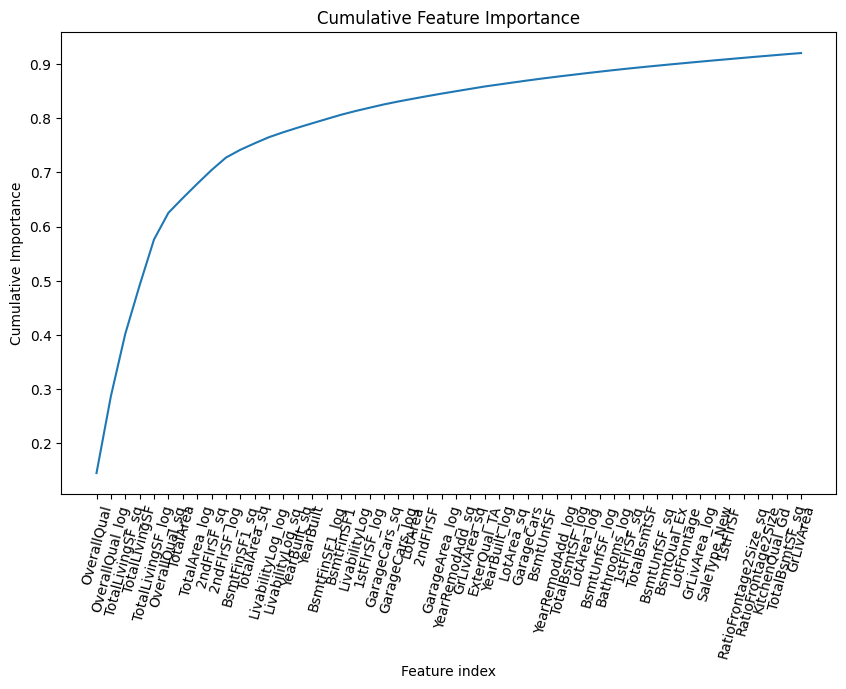

In [30]:
import matplotlib.pyplot as plt
tree_importances = pd.Series(
    gb_reg.feature_importances_, index=X.columns) \
        .sort_values(ascending=False)

sorted_indices = np.argsort(tree_importances)[::-1]  # Sort in descending order
cumulative_importances = np.cumsum(tree_importances[sorted_indices])
index_list = tree_importances.sort_values(ascending=False).index.tolist()[:50]

plt.figure(figsize=(10, 6))
plt.plot(cumulative_importances[:50])
plt.xticks(ticks=range(0, len(index_list)), labels=index_list, rotation=75)
plt.xlabel('Feature index')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.show()

In [ ]:
# Kaggle: Score: 0.12965

In [ ]:
# gb_reg = GradientBoostingRegressor(random_state=28, 
#                                    n_estimators=500,
#                                    validation_fraction=0.1,
#                                    n_iter_no_change=30,
#                                    verbose=0,
#                                    max_depth=9,
#                                    learning_rate=0.05,
#                                    max_features=0.9,
#                                    subsample=0.5,
#                                    min_samples_split=30)
# Kaggle: Score: 0.12965